In [0]:
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

In [0]:
from IPython.display import clear_output

Task: Language Classification

The aim of this project is to build a model which predicts the language given a name (which is essentially a sequence of characters)

<h3> Data Preprocessing </h3>

In [0]:
languages = []
data = []
X = []
y = []

with open('name2lang.txt', 'r') as f: 
    for line in f:
        line = line.split(',')
        name = line[0].strip()
        lang = line[1].strip()
        if not lang in languages:
            languages.append(lang)
        X.append(name)
        y.append(lang)
        data.append((name, lang))

n_languages = len(languages)

In [79]:
print(languages)

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


There are totally 18 languages

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

<h4> Creating Vector Representation for Inputs </h4>

<p> Since the possible inputs are set of all english albhabets(capital and small) we represent each alphabet using a one hot vector. The size of each input vector is equal to the total number of characters (n_letters) </p>

In [0]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [82]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [0]:
# Creating one hot representation for each input
def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters) # Tensor for word representation, which is basically combination of 
                                               # vector representation of each character in the word
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        #print(pos)
        rep[index][0][pos] = 1 # index corresponds to number of letters
                               # 0 corresponds to batch
                               # pos corresponds to character position in the one hot encoding

    return rep

In [84]:
name_rep('Kim') # note 'i' represented by 1 at 8th index

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])

<h4> Creating Vector Representation for Output </h4>

In [0]:
def lang_rep(lang):
  return torch.tensor([languages.index(lang)],dtype = torch.long)

In [86]:
languages.index('English')

12

In [87]:
lang_rep('English')

tensor([12])

<h4> Data Visualisation </h4>

In [0]:
count = {}
for l in languages: 
    count[l] = 0
for d in data:
    count[d[1]] += 1 # d[0] is name, d[1] is language

In [89]:
print(count)

{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


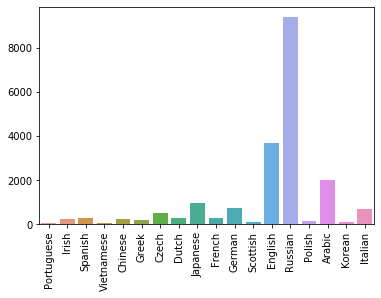

In [90]:
plt_ = sns.barplot(list(count.keys()), list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(), rotation=90)
plt.show()

The number of English , Russian and Arabic datapoints are very large compared to other languages, which may cause some problems while building the model


<h3> RNN Model </h3>

In [0]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN,self).__init__() #calling init of parent class
    self.hidden_size = hidden_size
    self.rnn_cell = nn.RNN(input_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)                                                           
    self.softmax = nn.LogSoftmax(dim = 1) 

  def forward(self,input_, hidden=None, batch_size = 1):
    out, hidden = self.rnn_cell(input_,hidden) # hidden_shape => (1,batch_size, 128)
    output = self.h2o(hidden.view(-1, self.hidden_size)) 
    # (1,batch_size , hidden_size) => (1 x batch_size, hidden_size)
    output = self.softmax(output)
    return output,hidden

  def init_hidden(self, batch_size=1): # We write this function here to ensure size of hidden state is uniform throughout code
    return torch.zeros(1,batch_size, self.hidden_size)# first index corresponds to number of characters
                                                      # second index corresponds to number of words





In [0]:
n_hidden = 128
net = RNN(n_letters, n_hidden, n_languages) 

<h3> Inference </h3>

Batching wll not used in inference and evaluation, only in training

In [0]:
#To see output of the untrained model for given name as input
def infer(net, name):
    net.eval() # We are not training the model
    name_ohe = name_rep(name) # Convert input to combination of one hot vector representation
    hidden = net.init_hidden() # Initialise hidden state
    
    #print(name_ohe.size()[0]) # Basically number of letters in input
    
    #No need of for loop as we are using nn.RNN - for i in range(name_ohe.size()[0]):
    output, hidden = net(name_ohe, hidden)
    
    if type(hidden) is tuple: # For LSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)
    

    return output

In [94]:
name_rep('Adam').size()

torch.Size([4, 1, 57])

In [95]:
output = infer(net, 'Adam')
#index = torch.argmax(output)
print(output)

tensor([[-2.9073, -2.9444, -2.8955, -2.8394, -2.8238, -2.8628, -2.7373, -3.0204,
         -2.8978, -2.8716, -2.9379, -2.9592, -2.9859, -2.7150, -2.9365, -2.9041,
         -2.9166, -2.9235]], grad_fn=<LogSoftmaxBackward>)


<h3> Creating Vector Representation for Batched Input </h3>

In [0]:
def batched_name_rep(names, max_word_size): # list of names and size of largest name
    rep = torch.zeros(max_word_size, len(names), n_letters) # len(names) is the batch size , n_letters is 57
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1 # pad represented by all zeros (see picture in video)
            # as for loop runs only till length of words, everything after that will be zer
    return rep

In [0]:
def print_char(name_reps): # visualize batching
    print(name_reps.size())
    name_reps = name_reps.view((-1, name_reps.size()[-1])) # not clear about -1
    print(name_reps.size())
    for t in name_reps: 
        if torch.sum(t) == 0:
            print('<pad>')
        else:
            index = t.argmax()
            print(all_letters[index])

In [98]:
out_ = batched_name_rep(['Shyam', 'Ram'], 5)
print(out_)
print(out_.shape)
print_char(out_)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0

<h3> Creating Vector Representation for Batched Output </h3>

In [0]:
# Instead of representing language using a single number
# we use array of numbers, with each number corresponding to
# one item in the batch
def batched_lang_rep(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = languages.index(lang)
    return rep

<h3> Custom DataLoader </h3>

In [0]:
def dataloader(npoints, X_,y_, verbose = False):
  # Input X_ and y_ are lists

  to_ret =[]
  for i in range(npoints):
    index = np.random.randint(len(X_))
    name , lang = X_[index], y_[index]
    to_ret.append((name,lang,name_rep(name), lang_rep(lang)))

  return to_ret
  


In [101]:
len(X_train)

16040

In [0]:
def batched_dataloader(npoints, X_, y_, verbose=False ):
    names = []
    langs = []
    X_lengths = [] # array containing lengths of each item in batch
    
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        X_lengths.append(len(name))
        names.append(name)
        langs.append(lang)
    max_length = max(X_lengths)
    
    names_rep = batched_name_rep(names, max_length) # this function internally
                                                    # does padding
    langs_rep = batched_lang_rep(langs)
    
    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, X_lengths, enforce_sorted = False) 
    # does packing
    
    #visualize packing
    if verbose:
        print(names_rep.shape, padded_names_rep.data.shape)
        print('--')
    
    if verbose:
        print(names)
        print_char(names_rep)
        print('--')
    
    if verbose:
        print_char(padded_names_rep.data)
        print('Lang Rep', langs_rep.data)
        print('Batch sizes', padded_names_rep.batch_sizes)
    
    
    return padded_names_rep, langs_rep

<h4> Visulize Padding and Packing </h4>

[10, 3, 57] => Maximum length of word is 10, 3 such words, and each word is represented by 57 dimension vector

[25,57] => Totally 27 letters = 10 + 9 + 8

As soon as 'Aldoworth' is over, batch size reduces from 3 to 2

As soon as 'Babintsev' is over, batch size reduces from 2 to 1


In [103]:
p, l = batched_dataloader(3, X_train, y_train, True)

torch.Size([10, 3, 57]) torch.Size([27, 57])
--
['Androsenko', 'Babintsev', 'Aldworth']
torch.Size([10, 3, 57])
torch.Size([30, 57])
A
B
A
n
a
l
d
b
d
r
i
w
o
n
o
s
t
r
e
s
t
n
e
h
k
v
<pad>
o
<pad>
<pad>
--
torch.Size([27, 57])
torch.Size([27, 57])
A
B
A
n
a
l
d
b
d
r
i
w
o
n
o
s
t
r
e
s
t
n
e
h
k
v
o
Lang Rep tensor([13, 13, 12])
Batch sizes tensor([3, 3, 3, 3, 3, 3, 3, 3, 2, 1])


<h3> Custom Evaluation Function </h3>


In [0]:
# no batching
def eval(net, n_points,k, X_, y_):

  data_ = dataloader(n_points,X_, y_)
  correct = 0 

  for name, lang, name_rep, lang_rep  in data_:
      output = infer(net, name) # forwards pass
      val, indices = output.topk(k) # obtaining top k values and their corresponding indices in the 18 dim output
                                    # (extension of torch.argmax)
        
      if lang_rep in indices: # if correct language in top k predictions
          correct += 1
            
  accuracy = correct/n_points
  return accuracy

In [105]:
eval(net, 1000, 1, X_test, y_test)


0.287

<h3> Train </h3>

In [0]:
def train_batch(net, opt, criterion, n_points):
    
    opt.zero_grad()
    loss = 0
    
    batch_input, batch_groundtruth = batched_dataloader(n_points, X_train, y_train, False)
    
    # for name, language, name_ohe, lang_rep in data_:

    #     hidden = net.init_hidden()

    #     for i in range(name_ohe.size()[0]): # forward pass
    #         output, hidden = net(name_ohe[i], hidden) # Note that same hidden variable is used on lhs and rhs
            
    output, hidden = net(batch_input) # Note: Input automatically passed to forward
                                      # as class is derived from nn.Module
    
    loss = criterion(output, batch_groundtruth)
    loss.backward(retain_graph=True) 
        
    opt.step()   # Entire backpropagation through time is done just in this one line
        
            
    return loss

In [0]:
net = RNN(n_letters, n_hidden, n_languages)
criterion = nn.NLLLoss() #negative log likelihood
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [108]:
%%time 
train_batch(net, opt, criterion, 256)

CPU times: user 56.9 ms, sys: 2.01 ms, total: 58.9 ms
Wall time: 59.7 ms


tensor(2.9158, grad_fn=<NllLossBackward>)

In [109]:
eval(net, 1000, 1, X_test, y_test)

0.012

<h3> Train Setup </h3>


In [0]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5):
    
    # Hyperparameters
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1) #torch.zeros?
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size))/(i + 1) 
        # Sum of all the previous losses
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test), 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
                      

<h3> Running the Model </h3>

Iteration 99 Top-1: 0.46109725685785535 Top-2: 0.6329177057356609 Loss 2.750166654586792


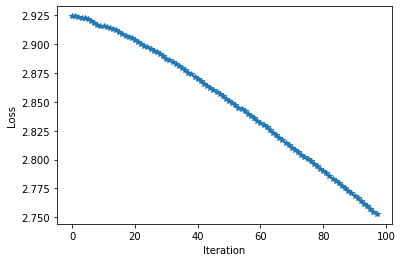

In [66]:
n_hidden = 128
net = RNN(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.0005, n_batches=100, batch_size = 256)

When lr was kept constant and batch size increased from 100 to 1000 accuracy did not improve but kept osciallting, possibly becuase learning rate was too small

Iteration 999 Top-1: 0.7433915211970075 Top-2: 0.8483790523690773 Loss 0.870783805847168


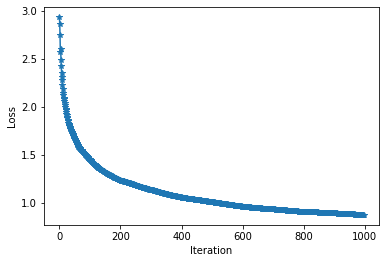

In [68]:
n_hidden = 128
net = RNN(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.2, n_batches=1000, batch_size = 256)

<h3> Confusion Matrix </h3

In [69]:
len(data)

20050

In [0]:
def get_confusion_mat(net, n_points,k, X_, y_):

  cfm = np.zeros((n_languages,n_languages))

  data_ = dataloader(n_points,X_, y_)
   

  for name, lang, name_rep, lang_rep  in data_:
      output = infer(net, name) # forwards pass
      val, index = output.topk(1) # obtaining top value and their corresponding indices in the 18 dim output
                                    # (extension of torch.argmax)
        
      cfm[languages.index(lang)][index] += 1    

  return cfm  


In [0]:
cfm = get_confusion_mat(net, 1000, 1, X_test, y_test)

In [112]:
# Per class accuracy
for lang_ind in range(18):
  total = np.sum(cfm[lang_ind])
  correct = cfm[lang_ind][lang_ind]
  print(languages[lang_ind],"---Total:",total,"--Accuracy :", correct /total)


Portuguese ---Total: 6.0 --Accuracy : 0.0
Irish ---Total: 13.0 --Accuracy : 0.23076923076923078
Spanish ---Total: 14.0 --Accuracy : 0.0
Vietnamese ---Total: 3.0 --Accuracy : 0.0
Chinese ---Total: 15.0 --Accuracy : 0.06666666666666667
Greek ---Total: 12.0 --Accuracy : 0.0
Czech ---Total: 30.0 --Accuracy : 0.0
Dutch ---Total: 14.0 --Accuracy : 0.0
Japanese ---Total: 53.0 --Accuracy : 0.0
French ---Total: 8.0 --Accuracy : 0.0
German ---Total: 34.0 --Accuracy : 0.0
Scottish ---Total: 2.0 --Accuracy : 0.0
English ---Total: 185.0 --Accuracy : 0.0
Russian ---Total: 463.0 --Accuracy : 0.0064794816414686825
Polish ---Total: 11.0 --Accuracy : 0.2727272727272727
Arabic ---Total: 103.0 --Accuracy : 0.0
Korean ---Total: 4.0 --Accuracy : 0.0
Italian ---Total: 30.0 --Accuracy : 0.0


In [0]:
import seaborn as sn
import pandas as pd

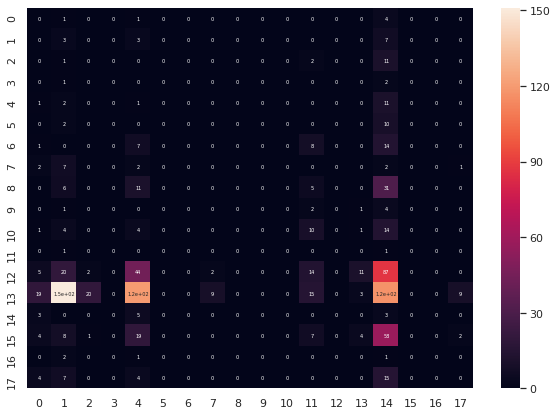

In [114]:
df_cm = pd.DataFrame(cfm, range(18),
                  range(18))
plt.figure(figsize = (10,7))
sn.set(font_scale=1)#for label size
sn.heatmap(cfm, annot=True,annot_kws={"size": 5})# font size

plt.show()
